# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

**Шаги для выбора локации:**

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Задача**
1. Обучить и проверите модель для каждого региона.
2. Расчитать средний запас предсказанного сырья и RMSE модели.
3. Рассчитать достаточный объём сырья для безубыточной разработки новой скважины. Сравнить полученный объём сырья со средним запасом в каждом регионе.
4. Просуммировать целевое значение объёма сырья на скважинах с максимальными значениями предсказаний.
5. Рассчитайть прибыль для полученного объёма сырья.
5. Посчитайте риски и прибыль для каждого региона.

**Описание данных**  
- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек;
- product — объём запасов в скважине (тыс. баррелей).

**Условия задачи:**  
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

## Загрузка и подготовка данных

In [361]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [362]:
data_zero = pd.read_csv('/datasets/geo_data_0.csv')
data_one = pd.read_csv('/datasets/geo_data_1.csv')
data_two = pd.read_csv('/datasets/geo_data_2.csv')

In [363]:
print(data_zero.head())
print(data_one.head())
print(data_two.head())

      id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
3  iJLyR -0.032172  0.139033  2.978566  168.620776
4  Xdl7t  1.988431  0.155413  4.751769  154.036647
      id         f0         f1        f2     product
0  kBEdx -15.001348  -8.276000 -0.005876    3.179103
1  62mP7  14.272088  -3.475083  0.999183   26.953261
2  vyE1P   6.263187  -5.948386  5.001160  134.766305
3  KcrkZ -13.081196 -11.506057  4.999415  137.945408
4  AHL4O  12.702195  -8.147433  5.004363  134.766305
      id        f0        f1        f2     product
0  fwXo0 -1.146987  0.963328 -0.828965   27.758673
1  WJtFt  0.262778  0.269839 -2.530187   56.069697
2  ovLUW  0.194587  0.289035 -5.586433   62.871910
3  q6cA6  2.236060 -0.553760  0.930038  114.572842
4  WPMUX -0.515993  1.716266  5.899011  149.600746


In [364]:
# проверим данные на пропуски ина соответствие типов данных
print(data_zero.info())
print(data_one.info())
print(data_two.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory 

In [365]:
# проверим данные на наличие полных дубликатов
print (data_zero.duplicated().sum(), data_one.duplicated().sum(), data_two.duplicated().sum())

0 0 0


In [366]:
# проверим выборки на ошибки в данных
def product(data):
    zero = 0
    minus = 0
    for i in range(data.shape[0]):
        if data.loc[i, 'product'] == 0:
            zero += 1
        else:
            if data.loc[i, 'product'] <0:
                minus += 1
    return zero, minus

print ('Kоличество ошибок (нулевые показатели запасов, отрицательные показатели запасов):')
print ('Регион 0', product(data_zero), 'Регион 1', product(data_one), 'Регион 2', product(data_two))

Kоличество ошибок (нулевые показатели запасов, отрицательные показатели запасов):
Регион 0 (1, 0) Регион 1 (8235, 0) Регион 2 (1, 0)


In [367]:
print ('Корреляция признаков', '', 'Регион 0', data_zero.corr(),'',
       'Регион 1', data_one.corr(), '', 'Регион 2', data_two.corr(), sep='\n')

Корреляция признаков

Регион 0
               f0        f1        f2   product
f0       1.000000 -0.440723 -0.003153  0.143536
f1      -0.440723  1.000000  0.001724 -0.192356
f2      -0.003153  0.001724  1.000000  0.483663
product  0.143536 -0.192356  0.483663  1.000000

Регион 1
               f0        f1        f2   product
f0       1.000000  0.182287 -0.001777 -0.030491
f1       0.182287  1.000000 -0.002595 -0.010155
f2      -0.001777 -0.002595  1.000000  0.999397
product -0.030491 -0.010155  0.999397  1.000000

Регион 2
               f0        f1        f2   product
f0       1.000000  0.000528 -0.000448 -0.001987
f1       0.000528  1.000000  0.000779 -0.001012
f2      -0.000448  0.000779  1.000000  0.445871
product -0.001987 -0.001012  0.445871  1.000000


In [368]:
# избавляемся от мультиколлинеарности
data_one_drop = data_one.drop('f2', axis=1)

In [369]:
# убираем столбцы не нужные нам для создания модели
data_zero_drop = data_zero.drop('id', axis=1)
data_one_drop = data_one.drop('id', axis=1)
data_two_drop = data_two.drop('id', axis=1)

### Вывод:
- пропусков и несоответствия типов данных в наших датасетах не выявлено
- невыявленно так же наличие полных дубликатов
- так как нам не известно, что означают признаки f0, f1 и f2 - мы не моодем проанализировать наличие ошибок в этих данных
- проверим на наличие ошибок значение запасов в скважине
- отрицаткльных значений не выявлено, однако в регионе №1 - выявлено большое количество 0-ых значений
- у нас не достаточно информации - является ли данное значение ошибочным либо это действительно "пустая" скважина
- с учетом что такое количество значений не превышает 10% от выборки, а так же может являться корректным - оставим данную графу без изменений
- как видно из таблицы, существет корреляция во всех регионах между признаком f2 и объемом запасов в скважине
- так же имеется некоторая обратная корреляция признаков f1 и f0 в нулевом регионе
- так как сами признаки нам не известны, но являются значимыми, примем что корреляция менее 0,5 является для наших признаков нормальной
- однако сильно выбивается корреляция признаков f2 и product во втором регионе - составляет практически 1
- для избежания искажения результатов в модели уберем в данной выборке один из мультиколлинеарных признаков - f2
- так же уберем из наших данных столбец 'id', так как он не нужен нам для задач нашего анализа

## Обучение и проверка модели

### Обучаем модель

In [370]:
# функция для обучения модели (линейная регрессия)
# обучающая и валидационные выборки разбиты в соотношении 75:25

def predictictions (data):
    features = data.drop(['product'], axis = 1)
    target = data['product']
    features_train, features_valid, target_train, target_valid = train_test_split(features, 
                                                                                  target, test_size=0.25, random_state=12345)
    model = LinearRegression()
    model.fit(features_train, target_train)
    return pd.Series(model.predict(features_valid)), target_valid

In [371]:
predicted_0, target_0 = predictictions(data_zero_drop)
predicted_1, target_1 = predictictions(data_one_drop)
predicted_2, target_2 = predictictions(data_two_drop)

### Расчет среднего запаса предсказанного сырья и RMSE модели

In [372]:
# функция для расчета среднего запаса и RMSE
def mean_rmse (target, predictions):
    mse = mean_squared_error(target, predictions)
    print('Средний запас сырья, тыс. баррелей:', round (predictions.mean(), 6))
    print('RMSE модели:', round (mse**0.5, 4))

In [373]:
print ('Регион 0:')
print (mean_rmse(target_0, predicted_0))
print ('')
print ('Регион 1:')
print (mean_rmse(target_1, predicted_1))
print ('')
print ('Регион 2:')
print (mean_rmse(target_2, predicted_2))

Регион 0:
Средний запас сырья, тыс. баррелей: 92.592568
RMSE модели: 37.5794
None

Регион 1:
Средний запас сырья, тыс. баррелей: 68.728547
RMSE модели: 0.8931
None

Регион 2:
Средний запас сырья, тыс. баррелей: 94.965046
RMSE модели: 40.0297
None


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc25e52b610>]],
      dtype=object)

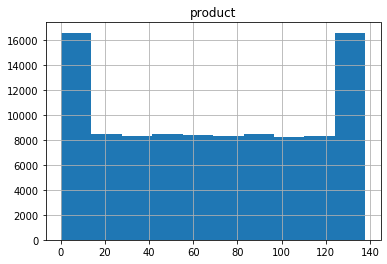

In [374]:
data_one.hist('product')

In [375]:
data_zero.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [376]:
data_two.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


### Вывод:
- наибольший средний запас предсказанного сырья находится в региое №2
- наилучший результат RMSE у региона №1
- низкое RMSE у региона №1 обусловлено особенностью распределения данных - выбросы в минимальных и максимальных значениях, и равномерным распределением около 70% данных
- значение RMSE в регионах №0 и №2 вписывается в межквартильный размах всей нашей выборки и поэтому можно считать работу нашей модели достаточно корректной

## Подготовка к расчёту прибыли

### Ключевые значения для расчета

In [377]:
# количество исследуемых точек при разведке
oilwell = 500
# количество лучших точек для разработки
best_well = 200
# бюджет на разработку скважин в регионе
budget = 10 ** 10
# доход с каждой единицы продукта
revenue = 450 * 10 ** 3

### Минимальный объем сырья в скважине для безубыточной добычи

In [378]:
# стоимость разработки одной скважины
price = budget / best_well
# минимальный объем сырья
min_volume = price / revenue
print ('Минимальный объем сырья в скважине для безубыточной добычи:', round(min_volume, 3), 'тыс. баррелей')

Минимальный объем сырья в скважине для безубыточной добычи: 111.111 тыс. баррелей


### Средний запас сырья по регионам

In [379]:
print('Регион 0:', round(data_zero['product'].mean(), 3))
print('Регион 1:', round(data_one['product'].mean(), 3))
print('Регион 2:', round(data_two['product'].mean(), 3))

Регион 0: 92.5
Регион 1: 68.825
Регион 2: 95.0


### Вывод:
- мимнимальный объем сырья в скважине для безубыточной добычи 111.111 тыс.баррелей
- если исходить из среднего запаса сырья в регионах, разработка скважин в любом регионе будет убыточной

## Расчёт прибыли и рисков 

### Прибыль по скважинам с максимальным значением предсказаний:

In [380]:
# функция расчета прибыли по выбранным скважинам и предсказаниям модели
def revenue_region(target, probabilities):
    target = pd.Series(target).reset_index(drop=True) 
    probabilities = pd.Series(probabilities).reset_index(drop=True)
    probabilities_sorted = probabilities.sort_values(ascending=False)
    best = target[probabilities_sorted.index][:best_well]
    revenue_reg = revenue * best.sum() - budget
    return revenue_reg

In [381]:
print ('Общая прибыль с 200 лучших предсказанных скважин региона 0:', round(revenue_region(target_0, predicted_0)/(10**9), 3), 'млрд.руб.')
print ('Общая прибыль с 200 лучших предсказанных скважин региона 1:', round(revenue_region(target_1, predicted_1)/(10**9), 3), 'млрд.руб.')
print ('Общая прибыль с 200 лучших предсказанных скважин региона 2:', round(revenue_region(target_2, predicted_2)/(10**9), 3), 'млрд.руб.')

Общая прибыль с 200 лучших предсказанных скважин региона 0: 3.321 млрд.руб.
Общая прибыль с 200 лучших предсказанных скважин региона 1: 2.415 млрд.руб.
Общая прибыль с 200 лучших предсказанных скважин региона 2: 2.71 млрд.руб.


### Средняя прибыль и риски с 1000 выборок

In [394]:
# функция Bootstrap. Кол-во выборок 1000, доверительный интервал 95%
# выбираем из 200 лучших скважин из 500 случайных точек из нашей выборки

sample = 1000 #кол-во выборок
state = np.random.RandomState(12345)
def bootstrap (target, predictions):
    values = []
    losses = 0
    for i in range(sample):
        target_sample = target.reset_index(drop=True).sample(n=oilwell, replace=True, random_state=state)
        probs_sample = predictions[target_sample.index]
        rev = revenue_region(target_sample, probs_sample)
        values.append(rev)    
#        if values[i]<0:
#            losses +=1
    values = pd.Series(values)
    values = values/(10**9)
    interval = (values.quantile(0.025), values.quantile(0.975))
    print("Средняя прибыль:", round(values.mean(), 3), 'млрд.руб')
    print("Доверительный интервал:", interval)
#    print("Риск убытка:", round((losses/sample)*100, 2), '%')
    print('Риск убытка', round((values < 0).mean()*100, 2), '%')

In [395]:
print ('Регион 0')
bootstrap(target_0, predicted_0)
print ('')
print ('Регион 1')
bootstrap(target_1, predicted_1)
print ('')
print ('Регион 2')
bootstrap(target_2, predicted_2)

Регион 0
Средняя прибыль: 0.396 млрд.руб
Доверительный интервал: (-0.11121554589049525, 0.9097669415534225)
Риск убытка 6.9 %

Регион 1
Средняя прибыль: 0.461 млрд.руб
Доверительный интервал: (0.07805081075174171, 0.8629520602637234)
Риск убытка 0.7 %

Регион 2
Средняя прибыль: 0.393 млрд.руб
Доверительный интервал: (-0.11222762537857565, 0.9345629145511635)
Риск убытка 6.5 %


### Вывод:
- по результатам отбора 200 лучших предсказанных скважин лидирует регион №0, с общей прогнозируемой прибылью в 3.321 млрд.руб.
- если ориентироваться на случайную выборку из 500 скважин, то единственным регионом удовлетворяющим условию "вероятность убытков менее 2,5%" является регион №1 со средней прибыльностью 0,461 млрд.руб.
- при условии если наша модель сможет предсказать наиболее полные по объему запасов скважины, тем самым сократив общую выборку, тогда стоит рассмотреть для добычи регион №0, так как там имеются наиболее богатые скважины
- если же отталкиваться от имеющихся данных, то на основании случайной выборки наиболее доходное будет месторождение №1 за счет минимазации рисков
